# <font color=dodgerblue> **A03 - Question # 2**

## Preprocess CIFAR 10 dataset 

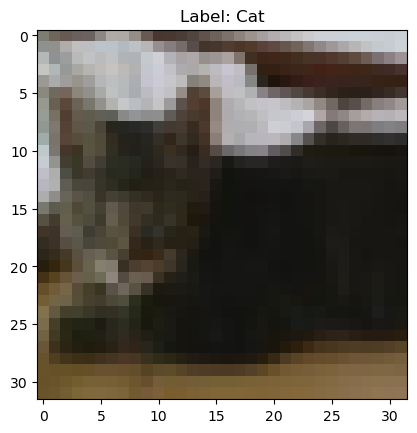

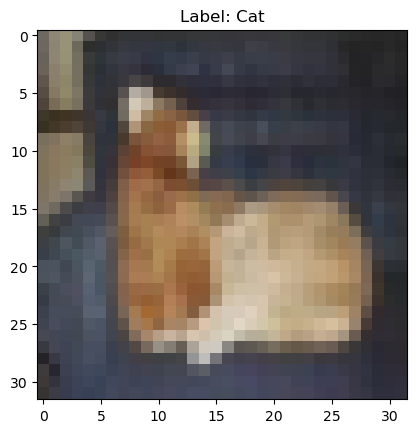

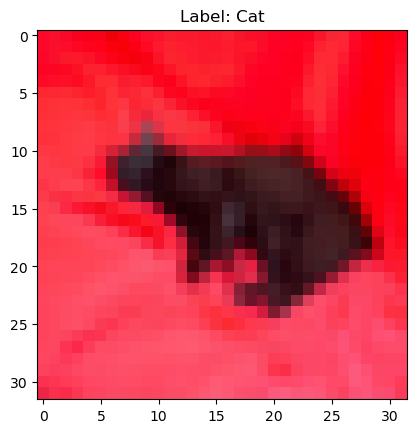

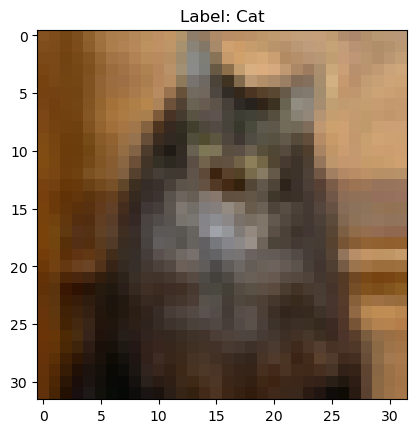

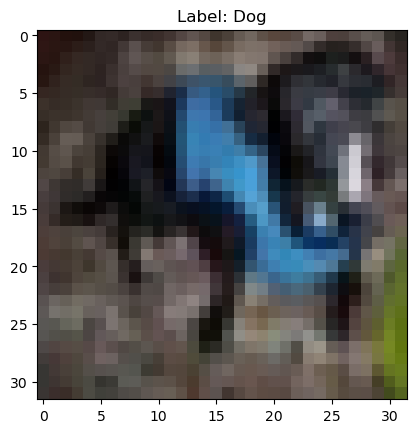

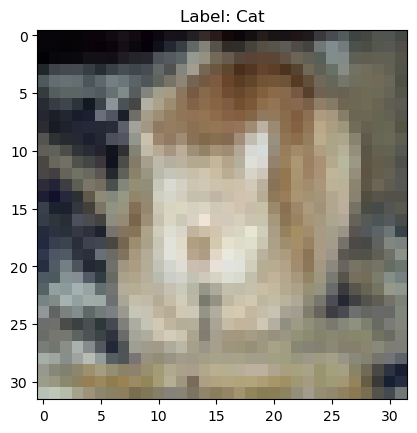

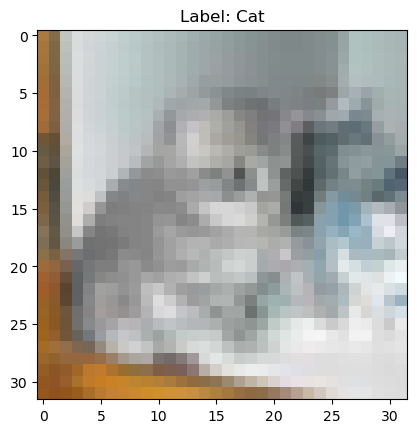

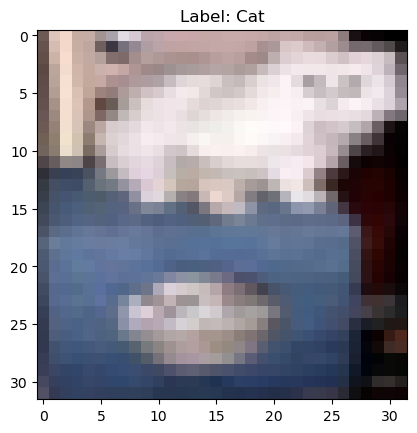

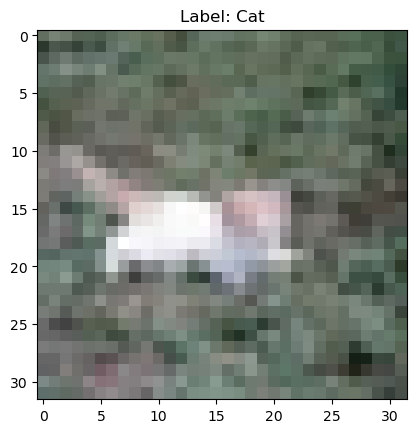

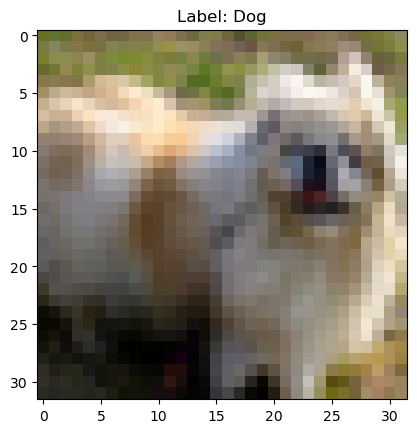

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Define CIFAR-10 label indices (adjust if using CIFAR-100 and different labels)
CAT_LABEL = 3
DOG_LABEL = 5

# Function to load a CIFAR batch file
def load_cifar_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Function to extract cat and dog images from a batch
def get_cat_dog_images(batch):
    data = batch[b'data']
    labels = batch[b'labels']  # Use [b'fine_labels'] for CIFAR-100 if needed

    # Find indices of cat and dog images
    cat_dog_indices = [i for i, label in enumerate(labels) if label in (CAT_LABEL, DOG_LABEL)]

    # Extract images and labels for cats and dogs
    images = data[cat_dog_indices]
    labels = [labels[i] for i in cat_dog_indices]
    
    # Reshape images to 32x32x3
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    
    return images, labels

# Specify the CIFAR batch file path
file_path = input("Enter the path to the CIFAR batch file: ").strip()  # User specifies file path

# Load the batch file and process it
try:
    batch = load_cifar_batch(file_path)
    cat_dog_images, cat_dog_labels = get_cat_dog_images(batch)

    # Display a few cat and dog images
    for i in range(min(10, len(cat_dog_images))):
        plt.imshow(cat_dog_images[i])
        label = "Cat" if cat_dog_labels[i] == CAT_LABEL else "Dog"
        plt.title(f"Label: {label}")
        plt.show()
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


## Implementing Vit from Scratch 

170498071/170498071 [==============================] - 163s 1us/step


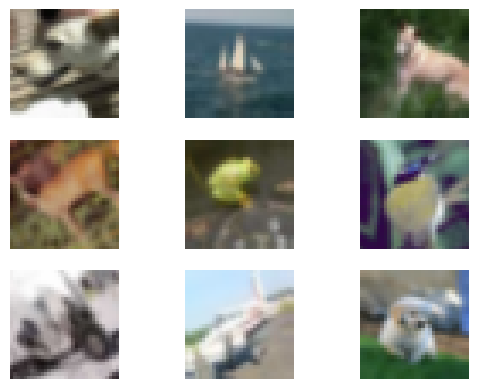

Data preprocessing completed!


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define data augmentation with parameter flexibility
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),       # Randomly rotate images (adjusted range)
    tf.keras.layers.RandomZoom(0.2),           # Randomly zoom in on images (adjusted range)
    tf.keras.layers.CenterCrop(28, 28),        # Center crop to 28x28
    tf.keras.layers.Resizing(32, 32)           # Resize back to original size
])

# Function to preprocess and augment data
def preprocess_data(x, y, augment=False):
    if augment:
        x = data_augmentation(x)
    return x, y

# Create a data pipeline for the training set with augmentation
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=10000)                # Shuffle the dataset with a smaller buffer
    .map(lambda x, y: preprocess_data(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(128)                                # Adjust batch size for flexibility
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Create a data pipeline for the test set (without augmentation)
test_dataset = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: preprocess_data(x, y, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(128)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Example: Preview augmented images
for images, labels in train_dataset.take(1):
    for i in range(9):  # Display first 9 images in a 3x3 grid
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Data preprocessing and augmentation completed!")


## Implementation of Vit

In [2]:
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:

# Configuration Parameters
img_size = 32  # CIFAR-10 image size
patch_size = 4  # Size of each patch
num_patches = (img_size // patch_size) ** 2
embed_dim = 64  # Embedding size for each patch
num_heads = 4  # Number of attention heads
mlp_dim = 128  # Dimensionality of MLP in Transformer
num_layers = 6  # Number of Transformer blocks
num_classes = 10  # Number of output classes
dropout_rate = 0.1  # Dropout rate
learning_rate = 1e-3  # Learning rate
batch_size = 64  # Batch size
epochs = 10  # Number of epochs

# Helper Functions
def create_patches(images, patch_size):
    """Divides images into patches."""
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID"
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

class PatchEncoder(layers.Layer):
    """Encodes patches using a dense layer and adds positional encoding."""
    def __init__(self, num_patches, embed_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(embed_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

def mlp_block(x, hidden_units, dropout_rate):
    """Defines the MLP block."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_block(x, num_heads, mlp_dim, dropout_rate):
    """Defines a Transformer block."""
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    mlp_output = mlp_block(x, hidden_units=[mlp_dim, x.shape[-1]], dropout_rate=dropout_rate)
    x = layers.Add()([x, mlp_output])
    x = layers.LayerNormalization()(x)
    return x

# Vision Transformer Model
def create_vit():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Step 1: Divide the image into patches
    patches = create_patches(inputs, patch_size)
    
    # Step 2: Encode patches with positional encoding
    encoded_patches = PatchEncoder(num_patches=num_patches, embed_dim=embed_dim)(patches)
    
    # Step 3: Apply Transformer blocks
    x = encoded_patches
    for _ in range(num_layers):
        x = transformer_block(x, num_heads=num_heads, mlp_dim=mlp_dim, dropout_rate=dropout_rate)
    
    # Step 4: Classify the output
    representation = layers.LayerNormalization()(x[:, 0])  # Use the [CLS] token
    outputs = layers.Dense(num_classes, activation='softmax')(representation)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Prepare and Compile the Model
def compile_vit():
    model = create_vit()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Prepare CIFAR-10 Dataset
def prepare_cifar10():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
    return x_train, y_train, x_test, y_test

# Main Training Loop
x_train, y_train, x_test, y_test = prepare_cifar10()
model = compile_vit()

# Train the model
model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)


Epoch 1/10
782/782 [==============================] - 600s 759ms/step - loss: 1.7248 - accuracy: 0.3619 - val_loss: 1.4244 - val_accuracy: 0.4686
Epoch 2/10
782/782 [==============================] - 537s 687ms/step - loss: 1.3403 - accuracy: 0.5149 - val_loss: 1.2398 - val_accuracy: 0.5505
Epoch 3/10
782/782 [==============================] - 532s 680ms/step - loss: 1.1987 - accuracy: 0.5671 - val_loss: 1.2450 - val_accuracy: 0.5531
Epoch 4/10
782/782 [==============================] - 511s 654ms/step - loss: 1.1150 - accuracy: 0.6001 - val_loss: 1.1382 - val_accuracy: 0.5895
Epoch 5/10
782/782 [==============================] - 506s 647ms/step - loss: 1.0492 - accuracy: 0.6248 - val_loss: 1.0973 - val_accuracy: 0.6088
Epoch 6/10
782/782 [==============================] - 502s 642ms/step - loss: 0.9910 - accuracy: 0.6482 - val_loss: 1.0611 - val_accuracy: 0.6182
Epoch 7/10
782/782 [==============================] - 503s 643ms/step - loss: 0.9443 - accuracy: 0.6646 - val_loss: 1.0318 -

## Save Model

In [ ]:
# Save the model in SavedModel format
model.save('vit_model_saved')


## Load Model

In [1]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('vit_model_saved')


## Evaluate Model 

313/313 [==============================] - 37s 114ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.65      0.68      1000
  automobile       0.82      0.70      0.76      1000
        bird       0.61      0.52      0.56      1000
         cat       0.48      0.50      0.49      1000
        deer       0.68      0.47      0.55      1000
         dog       0.56      0.60      0.58      1000
        frog       0.75      0.75      0.75      1000
       horse       0.58      0.80      0.67      1000
        ship       0.72      0.82      0.77      1000
       truck       0.71      0.78      0.74      1000

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.65     10000
weighted avg       0.66      0.66      0.65     10000



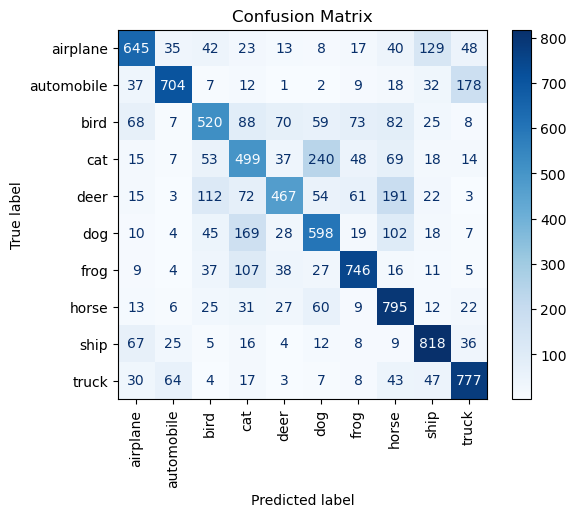

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(x_test, batch_size=batch_size)  # Use batch_size for efficient prediction
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions

# Flatten the true labels
y_test_flat = y_test.flatten()

# Classification Report
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Classification Report:")
print(classification_report(y_test_flat, y_pred_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))  # Larger figure for better readability
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


## CNN + MLP 

In [ ]:
# Visualize Training and Validation Metrics
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    """Plots training accuracy and loss curves."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Loss")

    plt.show()

# Call the function to plot metrics
plot_training_metrics(history)


Epoch 1/50
391/391 [==============================] - 57s 143ms/step - loss: 2.0790 - accuracy: 0.2193 - val_loss: 1.7713 - val_accuracy: 0.3815
Epoch 2/50
391/391 [==============================] - 58s 148ms/step - loss: 1.7600 - accuracy: 0.3470 - val_loss: 1.5598 - val_accuracy: 0.4423
Epoch 3/50
391/391 [==============================] - 59s 150ms/step - loss: 1.6306 - accuracy: 0.3996 - val_loss: 1.4374 - val_accuracy: 0.4868
Epoch 4/50
391/391 [==============================] - 58s 148ms/step - loss: 1.5421 - accuracy: 0.4366 - val_loss: 1.3769 - val_accuracy: 0.5112
Epoch 5/50
391/391 [==============================] - 58s 148ms/step - loss: 1.4670 - accuracy: 0.4663 - val_loss: 1.3073 - val_accuracy: 0.5373
Epoch 6/50
391/391 [==============================] - 58s 149ms/step - loss: 1.4030 - accuracy: 0.4941 - val_loss: 1.2503 - val_accuracy: 0.5588
Epoch 7/50
391/391 [==============================] - 58s 148ms/step - loss: 1.3513 - accuracy: 0.5127 - val_loss: 1.1941 - val_ac

INFO:tensorflow:Assets written to: cnn_mlp_hybrid_model\assets


INFO:tensorflow:Assets written to: cnn_mlp_hybrid_model\assets


## Load CNN + MLP Model

In [2]:
import tensorflow as tf

# Load the saved model
mlp_model = tf.keras.models.load_model('cnn_mlp_hybrid_model')

## Implement a ResNet model for Image Classification

313/313 [==============================] - 5s 17ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.78      0.79      1000
  automobile       0.84      0.85      0.85      1000
        bird       0.74      0.55      0.63      1000
         cat       0.55      0.53      0.54      1000
        deer       0.61      0.77      0.68      1000
         dog       0.60      0.68      0.64      1000
        frog       0.79      0.82      0.80      1000
       horse       0.77      0.80      0.78      1000
        ship       0.88      0.82      0.85      1000
       truck       0.87      0.78      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



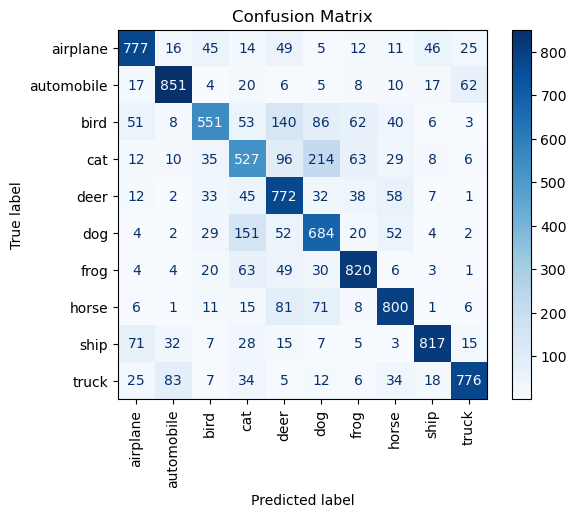

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test dataset
# The model outputs probabilities for each class
y_pred = cnn_mlp_model.predict(x_test, batch_size=config["batch_size"])  # Efficient batch-wise prediction
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions (argmax)

# Flatten the true labels to match predictions
y_test_flat = y_test.flatten()

# Generate the classification report
class_names = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]
print("Classification Report:")
print(classification_report(y_test_flat, y_pred_classes, target_names=class_names))

# Generate the confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))  # Larger plot for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca())  # Set colormap and axis rotation
plt.title("Confusion Matrix")
plt.show()


## Load ResNet Model 

In [5]:
from tensorflow.keras.models import load_model
resnet_model = load_model('./resnet_cifar10_transfer_learning.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize the images

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Load the pretrained ResNet50 model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Pretrained on ImageNet
    include_top=False,   # Exclude the top classification layer
    input_shape=(32, 32, 3)  # CIFAR-10 image size
)

# Freeze the base model's layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,  # Pretrained ResNet base
    layers.GlobalAveragePooling2D(),  # Add global average pooling
    layers.Dense(256, activation='relu'),  # Custom dense layer
    layers.Dropout(0.5),  # Regularization
    layers.Dense(128, activation='relu'),  # Additional dense layer
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=10  # Short training time for demonstration; adjust as needed
)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_training_history(history)

# Save the trained model
model.save('resnet_cifar10_transfer_learning.h5')


94765736/94765736 [==============================] - 26s 0us/step
Epoch 1/10
391/391 [==============================] - 104s 259ms/step - loss: 2.3255 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.0999
Epoch 2/10
391/391 [==============================] - 101s 258ms/step - loss: 2.3028 - accuracy: 0.0949 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
391/391 [==============================] - 106s 271ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
391/391 [==============================] - 108s 276ms/step - loss: 2.3027 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
391/391 [==============================] - 109s 280ms/step - loss: 2.3027 - accuracy: 0.0967 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/10
391/391 [==============================] - 110s 280ms/step - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
391/391 [==============================] - 109s

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=5  # Fine-tuning with fewer epochs
)


Epoch 1/5
391/391 [==============================] - 1912s 5s/step - loss: 3.0823 - accuracy: 0.1092 - val_loss: 103.3532 - val_accuracy: 0.0980
Epoch 2/5
391/391 [==============================] - 1903s 5s/step - loss: 2.3783 - accuracy: 0.1328 - val_loss: 2.8797 - val_accuracy: 0.1617
Epoch 3/5
391/391 [==============================] - 1905s 5s/step - loss: 2.2723 - accuracy: 0.1551 - val_loss: 2.2423 - val_accuracy: 0.2529
Epoch 4/5
391/391 [==============================] - 1909s 5s/step - loss: 2.1836 - accuracy: 0.1962 - val_loss: 2.1191 - val_accuracy: 0.3098
Epoch 5/5
391/391 [==============================] - 1916s 5s/step - loss: 2.0795 - accuracy: 0.2456 - val_loss: 1.9694 - val_accuracy: 0.3842


313/313 [==============================] - 45s 138ms/step
Classification Report:
              precision    recall  f1-score   support

    airplane       0.43      0.37      0.40      1000
  automobile       0.38      0.39      0.38      1000
        bird       0.33      0.08      0.12      1000
         cat       0.30      0.23      0.26      1000
        deer       0.42      0.26      0.32      1000
         dog       0.31      0.36      0.33      1000
        frog       0.38      0.63      0.48      1000
       horse       0.44      0.36      0.39      1000
        ship       0.44      0.75      0.56      1000
       truck       0.36      0.41      0.38      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.36     10000
weighted avg       0.38      0.38      0.36     10000



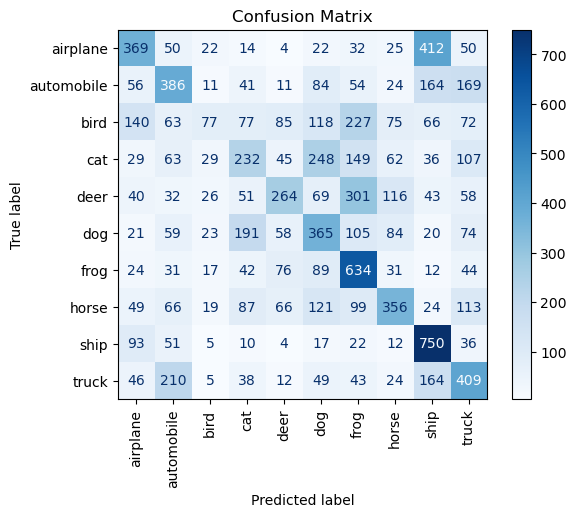

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
report = classification_report(
    y_test_classes, y_pred_classes,
    target_names=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
)
print(report)

# Save the report to a file
with open('classification_report.txt', 'w') as f:
    f.write(report)

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Overall Accuracy
overall_accuracy = np.trace(cm) / np.sum(cm)
print(f"Overall Accuracy: {overall_accuracy:.2%}")


In [8]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


## Compare the performance

In [18]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [19]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [20]:
print(f"y_test shape: {y_test.shape}")


y_test shape: (10000, 10)


In [21]:
# One-hot encoding the labels (if needed)
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Ensure this matches the label encoding
    metrics=['accuracy']
)

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


NameError: name 'x_val' is not defined

## Deploying Machine

313/313 [==============================] - 41s 127ms/step


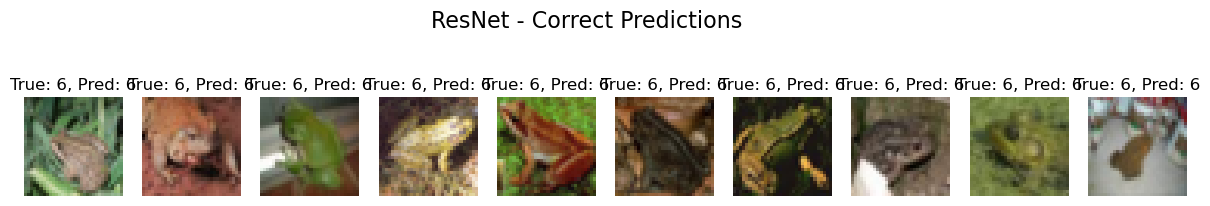

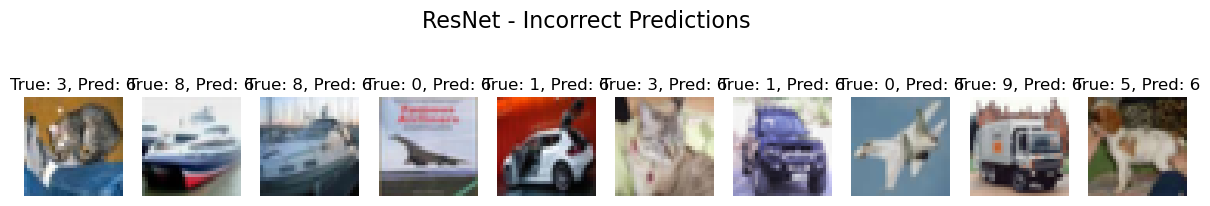

313/313 [==============================] - 52s 160ms/step


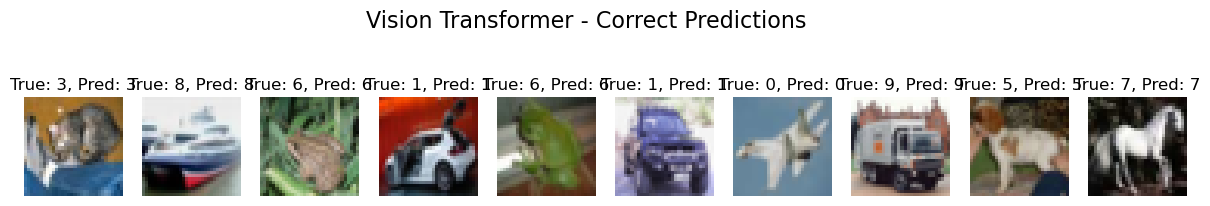

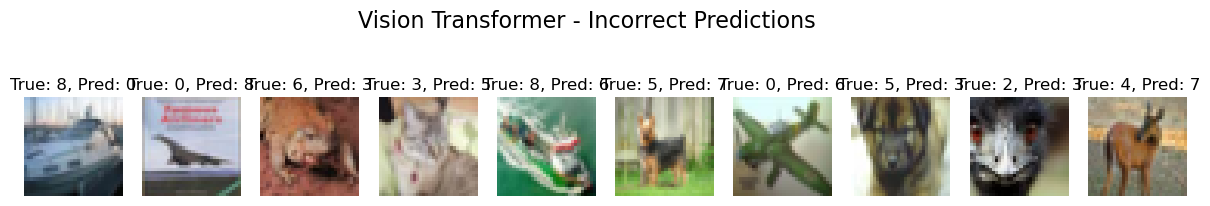

313/313 [==============================] - 5s 16ms/step


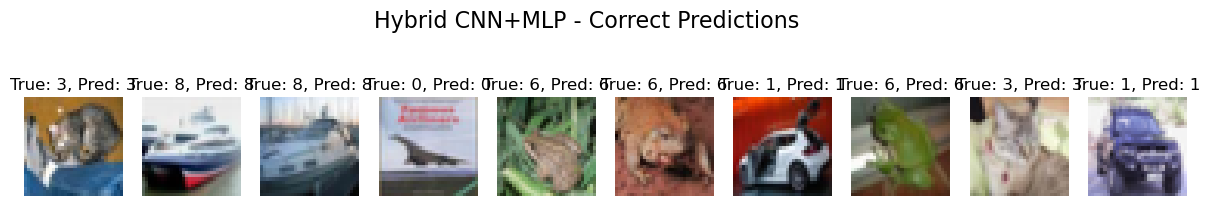

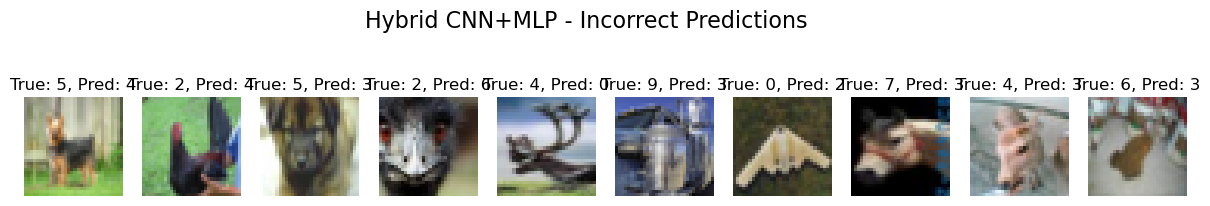

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset as an example
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the test data
x_test = x_test.astype("float32") / 255.0
y_test = y_test.flatten()  # Convert labels to 1D for comparison

# Function to visualize results
def visualize_results(model, model_name, x_test, y_test, num_images=10):
    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test

    # Select indices of correct and incorrect predictions
    correct_indices = np.where(predicted_labels == true_labels)[0][:num_images]
    incorrect_indices = np.where(predicted_labels != true_labels)[0][:num_images]

    # Plot correct predictions
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(correct_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} - Correct Predictions", fontsize=16)
    plt.show()

    # Plot incorrect predictions
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(incorrect_indices):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
        plt.axis('off')
    plt.suptitle(f"{model_name} - Incorrect Predictions", fontsize=16)
    plt.show()

# Visualize results for each model
visualize_results(resnet_model, "ResNet", x_test, y_test)
visualize_results(model, "Vision Transformer", x_test, y_test)
visualize_results(mlp_model, "Hybrid CNN+MLP", x_test, y_test)


## Plot training and validation accuracy and loss curves 

In [14]:
import matplotlib.pyplot as plt

# CNN Data
cnn_epochs = list(range(1, 11))
cnn_train_accuracy = [0.3619, 0.5149, 0.5671, 0.6001, 0.6248, 0.6482, 0.6646, 0.6775, 0.6879, 0.7002]
cnn_val_accuracy = [0.4686, 0.5505, 0.5531, 0.5895, 0.6088, 0.6182, 0.6312, 0.6474, 0.6589, 0.6569]
cnn_train_loss = [1.7248, 1.3403, 1.1987, 1.115, 1.0492, 0.991, 0.9443, 0.9094, 0.8748, 0.8404]
cnn_val_loss = [1.4244, 1.2398, 1.245, 1.1382, 1.0973, 1.0611, 1.0318, 0.9966, 0.9744, 0.9846]

# ViT Data (Truncated for simplicity)
vit_epochs = list(range(1, 51))
vit_train_accuracy = [
    0.2193, 0.3470, 0.3996, 0.4366, 0.4663, 0.4941, 0.5127, 0.5318, 0.5481, 0.5623, 0.5771, 0.5898, 0.6037, 0.6132, 0.6226, 
    0.6298, 0.6372, 0.6471, 0.6550, 0.6625, 0.6742, 0.6777, 0.6844, 0.6890, 0.6959, 0.7005, 0.7062, 0.7117, 0.7163, 0.7225,
    0.7258, 0.7272, 0.7327, 0.7404, 0.7424, 0.7492, 0.7513, 0.7562, 0.7597, 0.7626, 0.7694, 0.7730, 0.7731, 0.7790, 0.7789,
    0.7853, 0.7884, 0.7932, 0.7946, 0.8018
]
vit_val_accuracy = [
    0.3815, 0.4423, 0.4868, 0.5112, 0.5373, 0.5588, 0.5787, 0.5897, 0.6032, 0.6114, 0.6206, 0.6287, 0.6343, 0.6442, 0.6525,
    0.6504, 0.6654, 0.6638, 0.6781, 0.6805, 0.6899, 0.6905, 0.6930, 0.6954, 0.7029, 0.6980, 0.7096, 0.7103, 0.7149, 0.7136,
    0.7185, 0.7213, 0.7241, 0.7242, 0.7251, 0.7259, 0.7270, 0.7329, 0.7362, 0.7356, 0.7314, 0.7337, 0.7292, 0.7404, 0.7390,
    0.7435, 0.7439, 0.7375
]
# Data from ResNet logs
resnet_epochs = list(range(1, 11))  # ResNet ran for 10 epochs
resnet_train_accuracy = [0.1000, 0.0949, 0.0978, 0.0964, 0.0967, 0.0984, 0.0976, 0.0965, 0.0984, 0.0993]
resnet_val_accuracy = [0.0999, 0.1000, 0.1000, 0.1000, 0.1001, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]


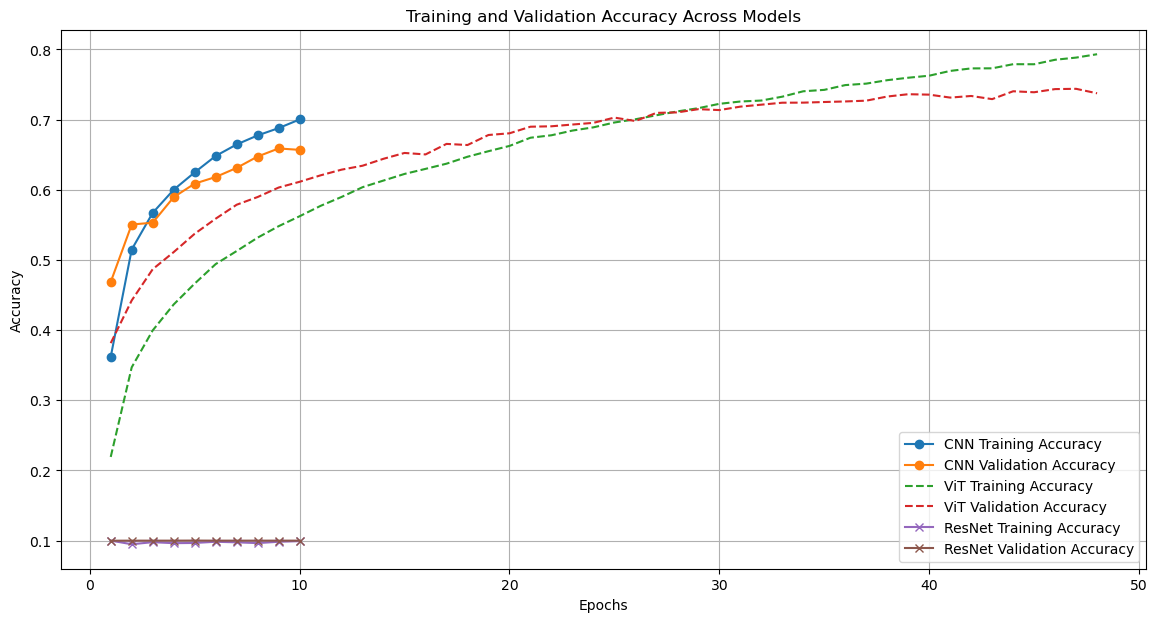

In [15]:
# Adjust lengths for consistency (assuming similar mismatch issues)
resnet_epochs = resnet_epochs[:len(resnet_val_accuracy)]  # Match the length of ResNet validation accuracy
vit_epochs = vit_epochs[:len(vit_val_accuracy)]  # Match the length of ViT validation accuracy
cnn_epochs = cnn_epochs[:len(cnn_val_accuracy)]  # Match the length of CNN validation accuracy

# Plotting accuracy
plt.figure(figsize=(14, 7))

# CNN Accuracy
plt.plot(cnn_epochs, cnn_train_accuracy[:len(cnn_epochs)], label='CNN Training Accuracy', marker='o')
plt.plot(cnn_epochs, cnn_val_accuracy, label='CNN Validation Accuracy', marker='o')

# ViT Accuracy
plt.plot(vit_epochs, vit_train_accuracy[:len(vit_epochs)], label='ViT Training Accuracy', linestyle='dashed')
plt.plot(vit_epochs, vit_val_accuracy, label='ViT Validation Accuracy', linestyle='dashed')

# ResNet Accuracy
plt.plot(resnet_epochs, resnet_train_accuracy[:len(resnet_epochs)], label='ResNet Training Accuracy', marker='x')
plt.plot(resnet_epochs, resnet_val_accuracy, label='ResNet Validation Accuracy', marker='x')

# Labels, Legends, and Title
plt.title('Training and Validation Accuracy Across Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()
